### Building Logistic Regression Classifier in Python

In [2]:
# Importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy import stats

%matplotlib inline

### Utility Code

In [3]:
import numpy as np

def treat_outliers(data, method='capping', factor=1.5):
    """
    Treat outliers in a dataset.

    Parameters:
    - data (array-like): The input data containing outliers.
    - method (str): The method for outlier treatment. 'capping' (default) caps the outliers.
    - factor (float): A parameter for controlling the extent of capping.

    Returns:
    - treated_data (array-like): The data with outliers treated.
    """

    if method == 'capping':
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1

        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        treated_data = np.clip(data, lower_bound, upper_bound)

        return treated_data

    else:
        raise ValueError("Unsupported outlier treatment method. Use 'capping'.")


import pandas as pd

def create_dummy_variables(data, columns_to_encode):
    """
    Create dummy variables (one-hot encoding) for specified columns in a Pandas DataFrame.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data.
    - columns_to_encode (list): A list of column names to one-hot encode.

    Returns:
    - data_with_dummies (DataFrame): The DataFrame with dummy variables added.
    """
    data_with_dummies = pd.get_dummies(data, columns=columns_to_encode)
    return data_with_dummies



In [4]:
data = pd.read_csv('bank-additional-full.csv', sep= ';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
### Recoding Target variable to 1 or 0 instead of 'yes' or 'no'
data['Target'] = data.y.apply(lambda x : '1' if x == 'yes' else '0')
data.drop(['y'], axis =1, inplace = True)

,job,Failure,Success,success_rate
0,admin.,9070,1352,12.972558
1,blue-collar,8616,638,6.894316
2,entrepreneur,1332,124,8.516484
3,housemaid,954,106,10.000000
4,management,2596,328,11.217510
5,retired,1286,434,25.232558
6,self-employed,1272,149,10.485574
7,services,3646,323,8.138070
8,student,600,275,31.428571
9,technician,6013,730,10.826042


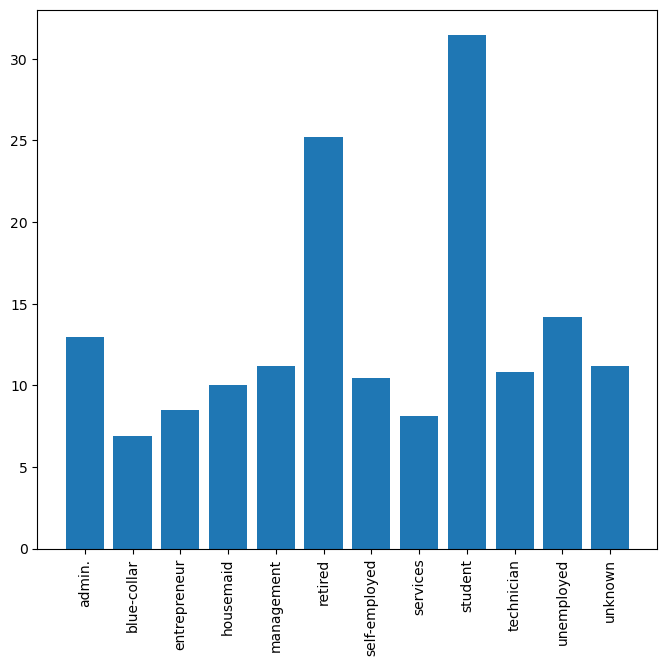

,marital,Failure,Success,success_rate
0,divorced,4136,476,10.320902
1,married,22396,2532,10.157253
2,single,9948,1620,14.004149
3,unknown,68,12,15.000000


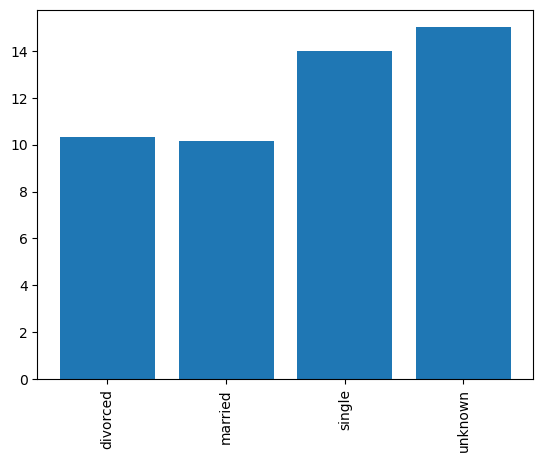

,education,Failure,Success,success_rate
0,basic.4y,3748,428,10.249042
1,basic.6y,2104,188,8.202443
2,basic.9y,5572,473,7.824648
3,high.school,8484,1031,10.835523
4,illiterate,14,4,22.222222
5,professional.course,4648,595,11.348465
6,university.degree,10498,1670,13.724523
7,unknown,1480,251,14.500289


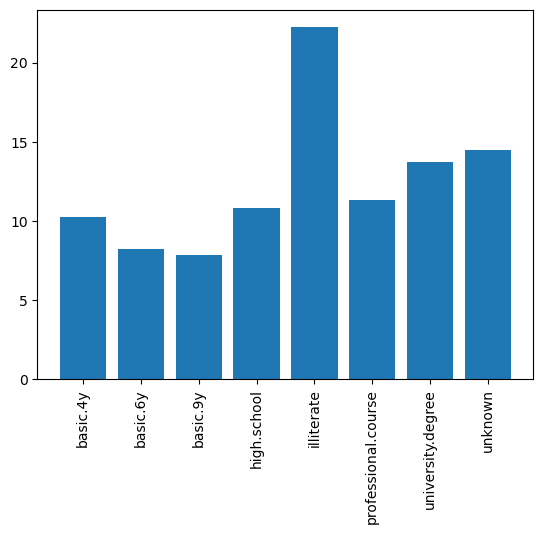

,default,Failure,Success,success_rate
0,no,28391,4197,12.878974
1,unknown,8154,443,5.152960
2,yes,3,0,0.000000


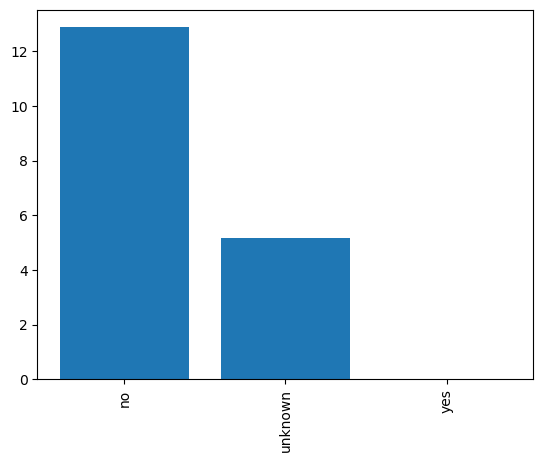

,housing,Failure,Success,success_rate
0,no,16596,2026,10.879605
1,unknown,883,107,10.808081
2,yes,19069,2507,11.619392


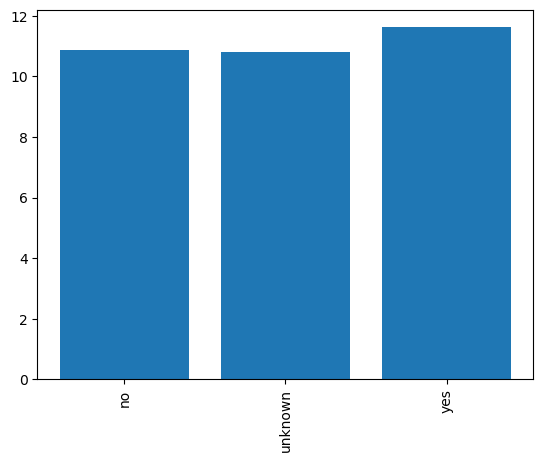

,loan,Failure,Success,success_rate
0,no,30100,3850,11.340206
1,unknown,883,107,10.808081
2,yes,5565,683,10.931498


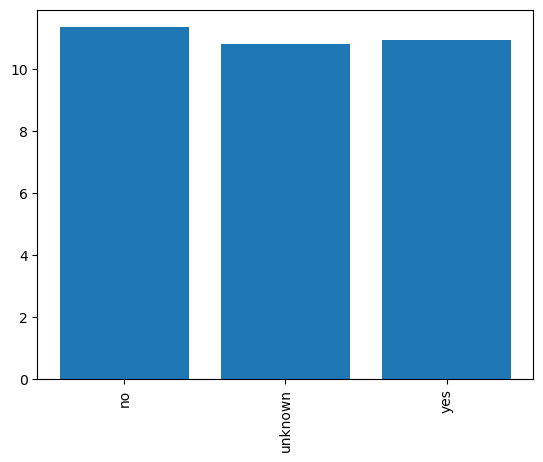

,contact,Failure,Success,success_rate
0,cellular,22291,3853,14.737607
1,telephone,14257,787,5.231321


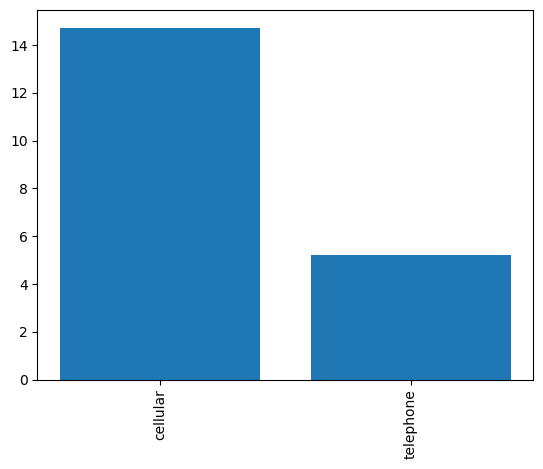

,month,Failure,Success,success_rate
0,apr,2093,539,20.478723
1,aug,5523,655,10.602137
2,dec,93,89,48.901099
3,jul,6525,649,9.046557
4,jun,4759,559,10.511470
5,mar,270,276,50.549451
6,may,12883,886,6.434745
7,nov,3685,416,10.143867
8,oct,403,315,43.871866
9,sep,314,256,44.912281


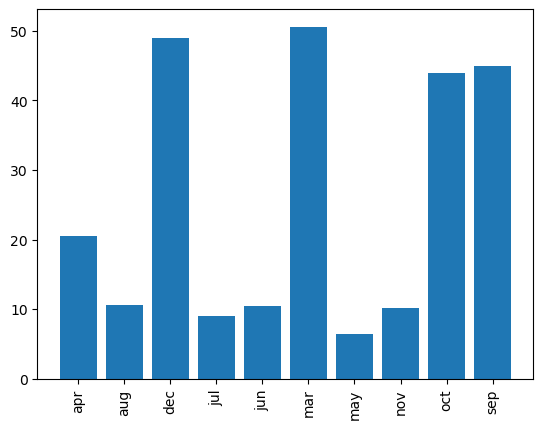

,day_of_week,Failure,Success,success_rate
0,fri,6981,846,10.808739
1,mon,7667,847,9.948320
2,thu,7578,1045,12.118752
3,tue,7137,953,11.779975
4,wed,7185,949,11.667076


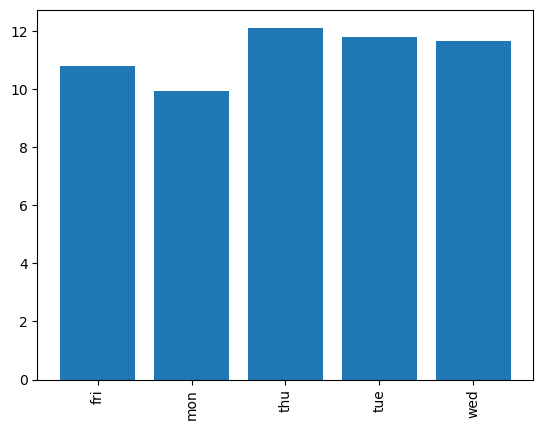

,poutcome,Failure,Success,success_rate
0,failure,3647,605,14.228598
1,nonexistent,32422,3141,8.832213
2,success,479,894,65.112891


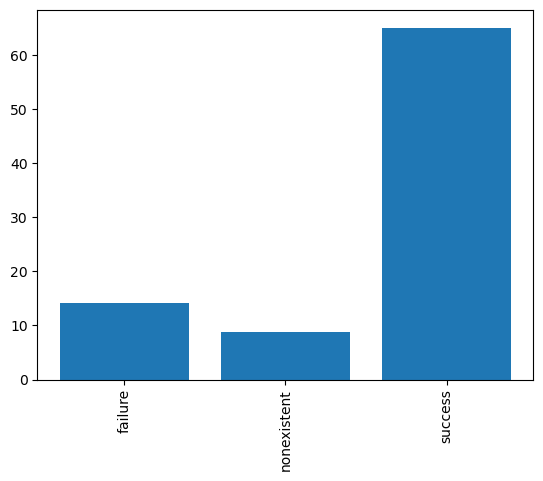

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 7))
### Basic Exploratory Data Analysis
for field in data.select_dtypes('object').columns:
    if field != 'Target':
        xtab = pd.crosstab(data[field], data.Target).reset_index()
        xtab.columns = [field, 'Failure', "Success"]
        xtab['success_rate'] = xtab['Success']*100/(xtab['Failure'] + xtab['Success'])
        display(xtab)
        categories = xtab[field]
        values = xtab['success_rate']
        plt.bar(categories, values)
        plt.xticks(rotation=90)
        plt.show()


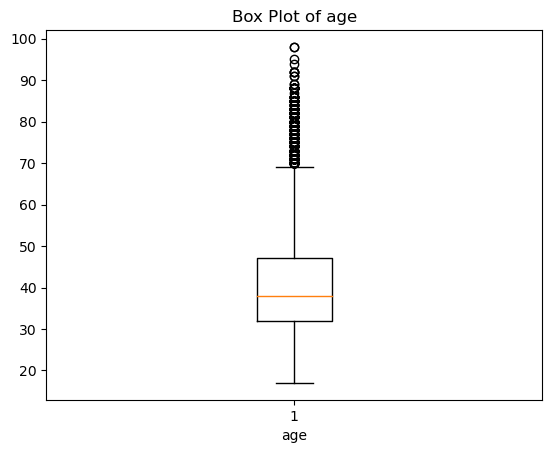

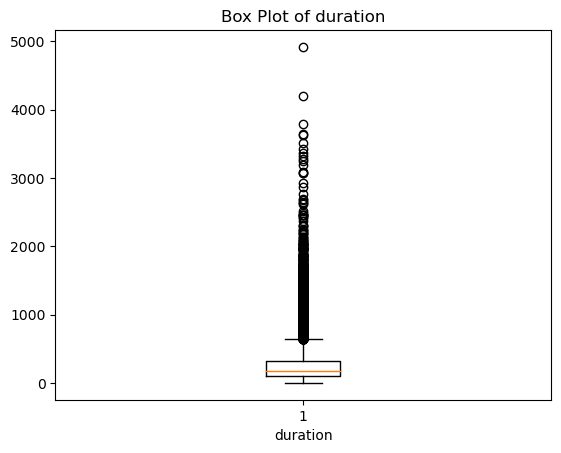

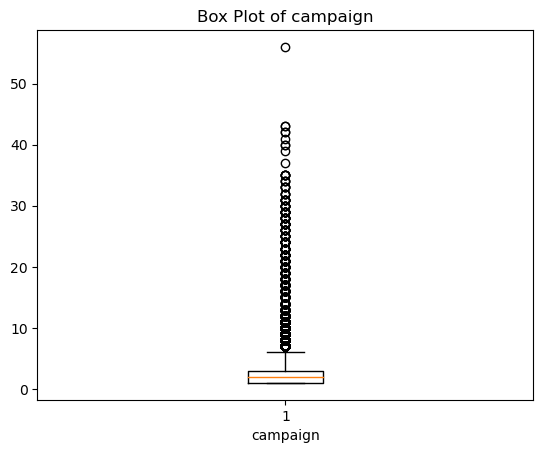

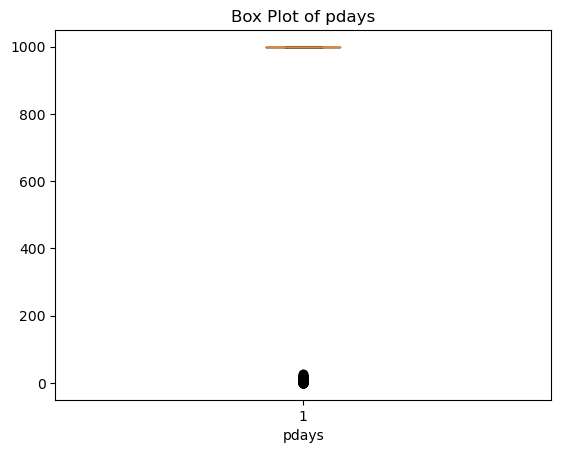

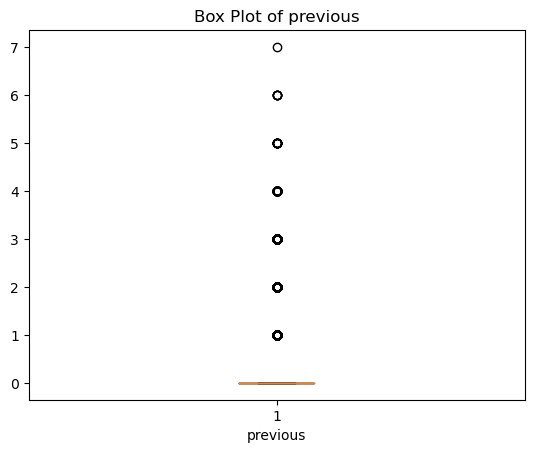

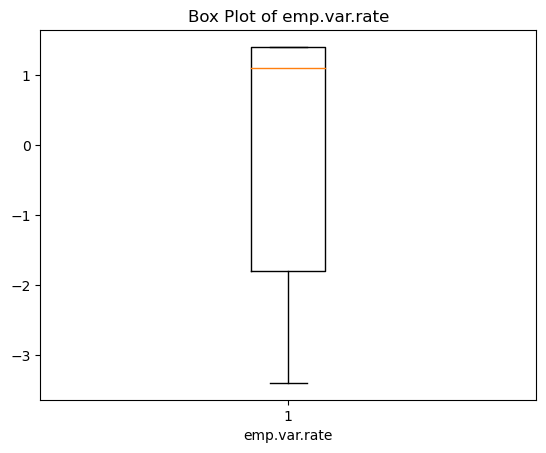

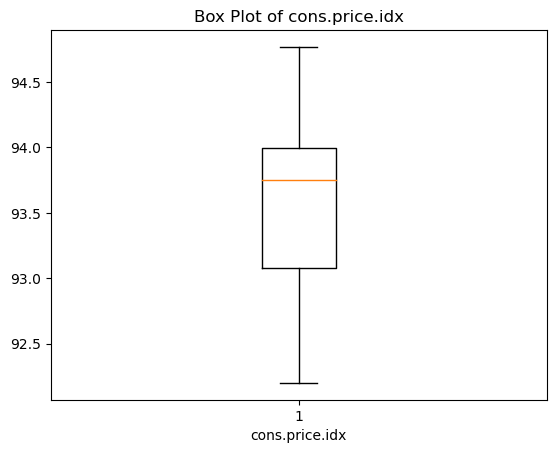

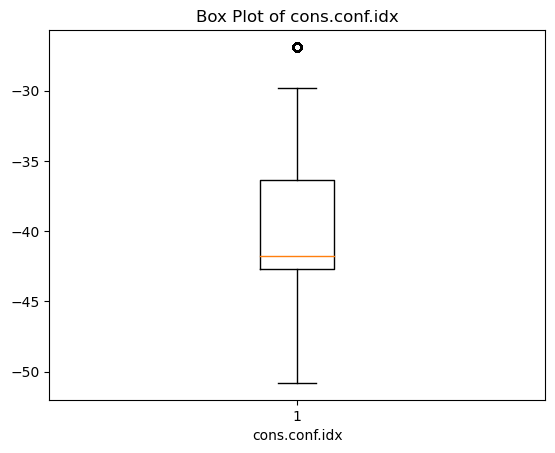

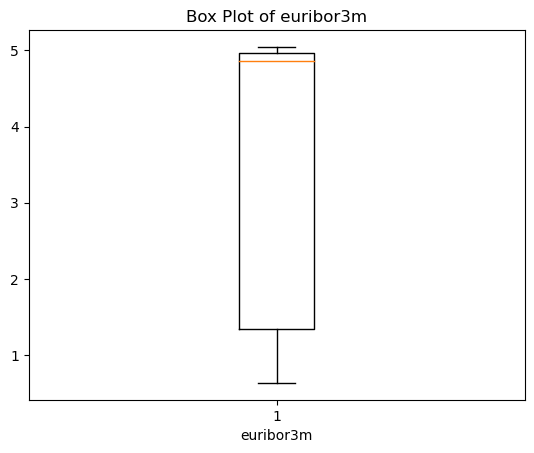

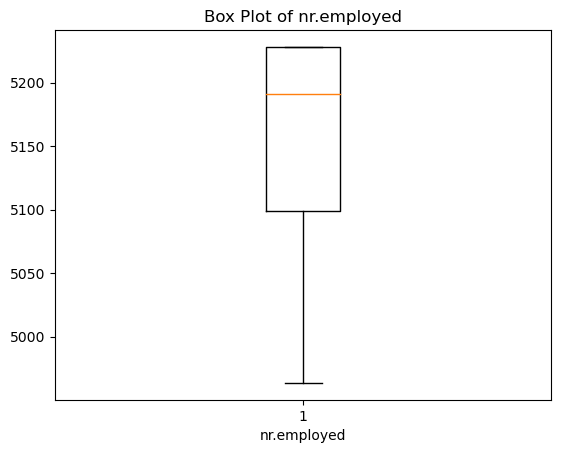

In [7]:
for field in data.select_dtypes(include=['number', 'float']).columns:
    idata = data[field]
    plt.boxplot(idata)
    plt.xlabel(field)
    plt.title('Box Plot of '+field)
    plt.show()

In [8]:
for field in data.select_dtypes(include=['number', 'float']).columns:
    data[field] = treat_outliers(data[field], method='capping', factor=1.5)

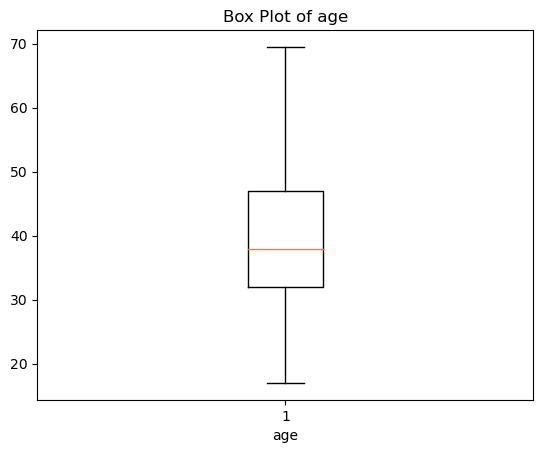

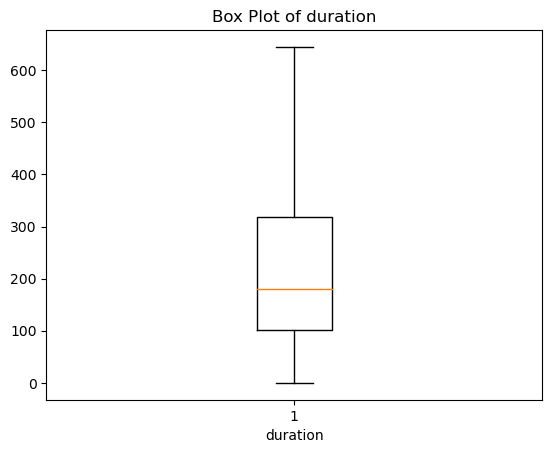

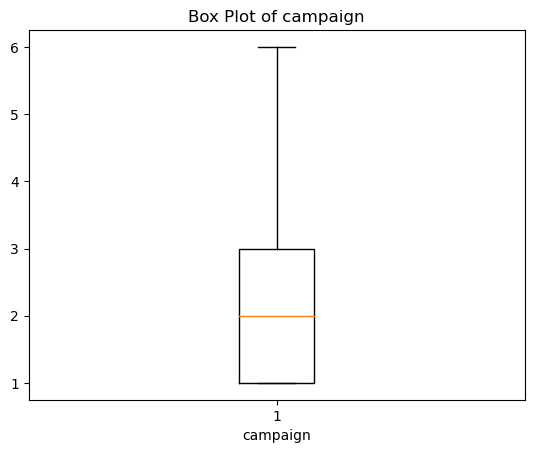

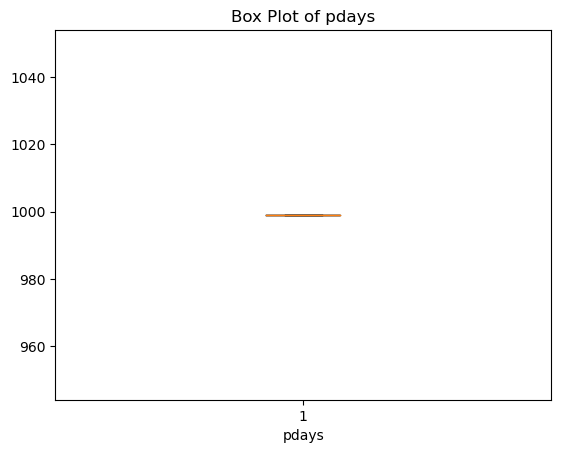

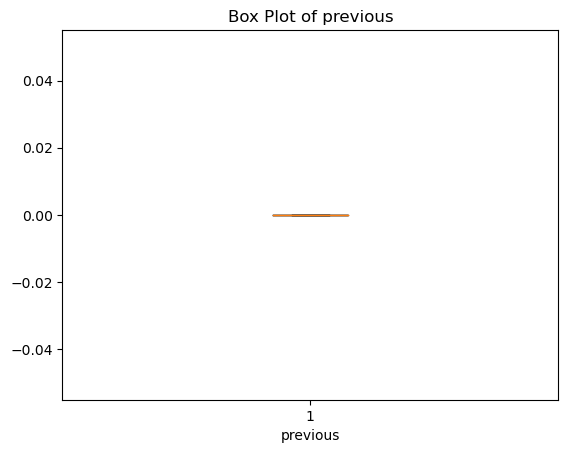

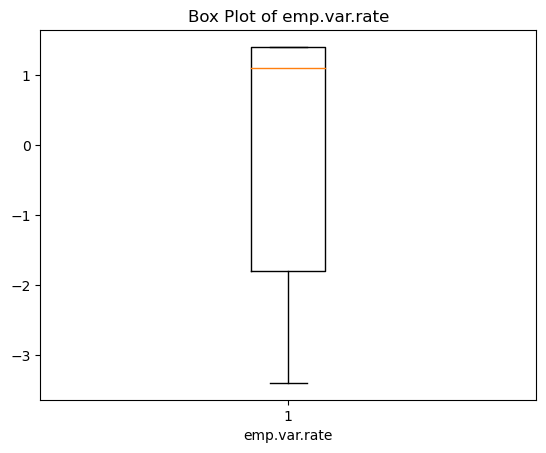

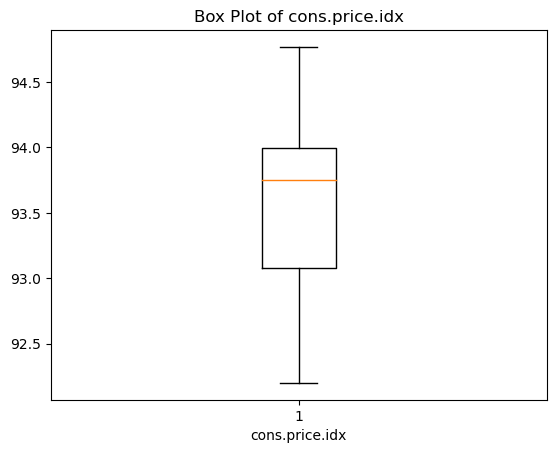

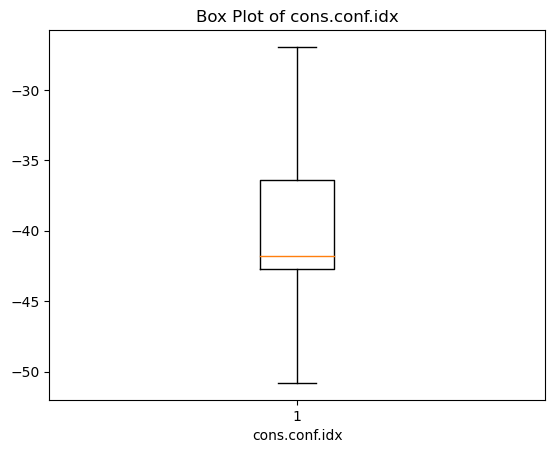

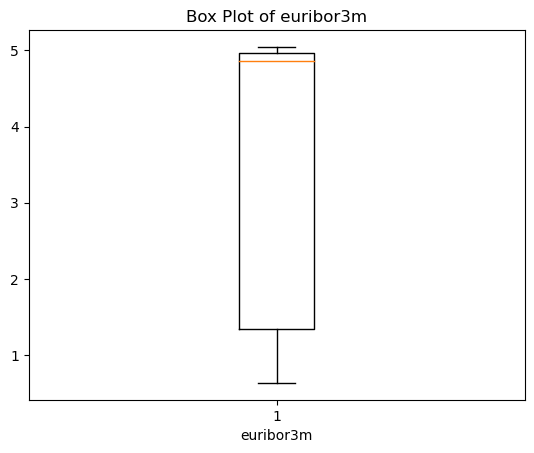

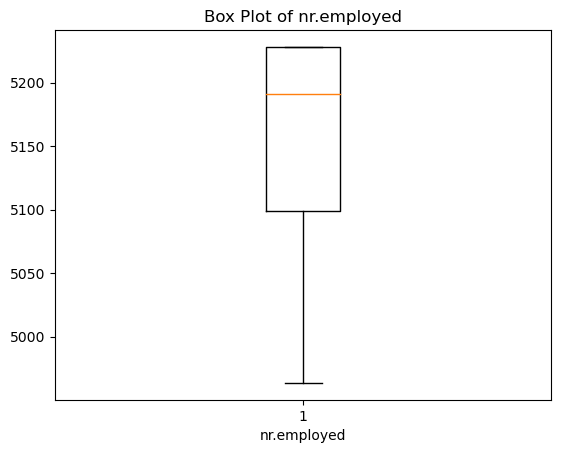

In [9]:
for field in data.select_dtypes(include=['number', 'float']).columns:
    idata = data[field]
    plt.boxplot(idata)
    plt.xlabel(field)
    plt.title('Box Plot of '+field)
    plt.show()

In [10]:
### Create Dummies
Categorial_Columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'day_of_week', 'poutcome']
data = create_dummy_variables(data, Categorial_Columns)


In [11]:
data.columns
X = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success']

Y = ['Target']

In [12]:
# Split into Train and Test
from sklearn.model_selection import train_test_split

# Sample data
X = data[X]  # Replace with your feature data
y = data[Y]  # Replace with your target data

# Split the data into a training set (usually 80%) and a testing set (usually 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# The 'test_size' parameter controls the proportion of data to be used for testing (in this case, 20%).
# 'random_state' is a seed for the random number generator, ensuring reproducibility.

# Now, you can use X_train and y_train for training your model, and X_test and y_test for testing its performance.


In [13]:
### Build Primary Logistic Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the logistic regression model
logistic_reg_model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logistic_reg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_reg_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a classification report
print(classification_report(y_test, y_pred))


c:\Users\Restart\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10968
           1       0.65      0.37      0.47      1389

    accuracy                           0.91     12357
   macro avg       0.79      0.67      0.71     12357
weighted avg       0.89      0.91      0.90     12357



In [14]:
# Disable scientific notation for coefficient printing
np.set_printoptions(suppress=True, precision=6)

variable_name = X_train.columns
variable_coefficient = logistic_reg_model.coef_

In [15]:
display(variable_name, variable_coefficient, logistic_reg_model.intercept_)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oc

array([[-0.005297,  0.008106, -0.039795,  0.030499,  0.      , -0.413689,
         0.190049,  0.01367 ,  0.069452, -0.010171,  0.013271, -0.153179,
        -0.068605, -0.034593, -0.0388  ,  0.181762, -0.052808, -0.098978,
         0.135179,  0.073414,  0.048055, -0.004689, -0.028855,  0.051752,
        -0.015127, -0.00774 , -0.001856,  0.044894, -0.072439, -0.07859 ,
         0.010348,  0.017215,  0.087115, -0.006656,  0.137687, -0.137547,
        -0.000109,  0.050956,  0.000068, -0.050994, -0.028277,  0.000068,
         0.02824 ,  0.132594, -0.132563, -0.089823,  0.211306, -0.025054,
         0.254371,  0.531702,  0.590777, -1.098018, -0.247991,  0.06314 ,
        -0.190379, -0.084882, -0.157585,  0.011724,  0.128216,  0.102557,
        -0.769079, -0.230778,  0.999888]])

array([0.000031])

In [16]:
logistic_reg_model.intercept_

array([0.000031])

In [17]:
### Saving the model
import joblib
joblib.dump(logistic_reg_model, 'logistic_reg_model.pkl')


['logistic_reg_model.pkl']

In [19]:
### Loading The Model 
joblib.dump(logistic_reg_model, 'logistic_reg_model.pkl')


['logistic_reg_model.pkl']